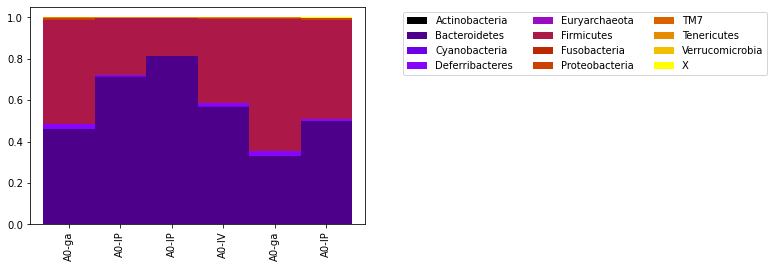

In [7]:
#code for the feces. We gonna read the otulumen and from that get the abundances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tsv_file="otu_table_feces.tsv"
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('otufeces.csv',index=False)
abu0=pd.read_csv("otufeces.csv")
tx0=pd.read_csv("fecestax.csv")
#---------we need to remove the streptomycin samples from the abundamce dataframe
dfA=pd.DataFrame(abu0)
dfA=dfA[dfA.columns.drop(list(dfA.filter(regex='S')))]
dfT=pd.DataFrame(tx0)
#uses the ID on the dfT dataframe, (left), and find it on the df dataframe, (right)
#the dataframe tax_abundance contains all the information: full taxonomy and the values of each sample#
tax_abundance=pd.merge(left=dfT,right=dfA,left_on='ID', right_on='ID')
#-------------------------
#dfA=tax_abundance.set_index('ID').T-->convenient way to transpose keeping the ID in the header
#list the name of columns in the dataframe df
#list(df.columns.values)

#--------------------------
#now we drop the samples that have a total abundance <7000
df=tax_abundance

day0=df[df.columns.drop(list(df.filter(regex='.d1'))+list(df.filter(regex='.d4')))]
day1=df[df.columns.drop(list(df.filter(regex='.d0'))+list(df.filter(regex='.d4')))]
day4=df[df.columns.drop(list(df.filter(regex='.d0'))+list(df.filter(regex='.d1')))]


currentDay=day0

#--------select the antibiotic you wanna plot
filter_col = [col for col in currentDay if col.startswith('A')]
modData=currentDay[['ID']+['Kingdom']+['Phylum']+['Class']+['Order']+['Family']+['Genus']+['Species']+filter_col]
#-----for all antibiotic in the same plot, choose modData=currentDay; For the full, all days, data frame, use modData=df
#modData=currentDay
#-----------------

from pandas.api.types import is_numeric_dtype
pd.options.mode.chained_assignment = None  # default='warn'

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        if sum(modData[column]) < 7000:
            modData.drop([column], axis=1, inplace=True)
#----------------------------
#-----now we normalize the samples in such a way each of them adds to 1

for column in modData.columns[8:]:
     if is_numeric_dtype(modData[column]):
        modData[column]=modData[column]/modData[column].sum()
#------------verification, we can comment this out
#for column in modData.columns[8:]:
#     if is_numeric_dtype(modData[column]):
#        ls=modData.sum(axis=0,skipna=True)
#        #check if everybody is normalized to one
#nd=modData.sum(numeric_only =True )
#for x in range(len(nd)):
#    print(nd[x]),
#---------------------------------


#-----------Block for sample <---> delivery correspondence-------------
#I start at 8 because the previous columns are taxonomy and  ID
headers=list(modData.columns[8:].values)
headers_list = pd.DataFrame(np.column_stack([headers]),columns=['SampleID'])
#------------
#now we convert the metada tsv file into a dataframe we can work with
# we seek a connection between the headers of tax_abundance with the delivery method listed in meta
tsv_file="metadata_feces.tsv"
csv_table=pd.read_table(tsv_file,sep='\t')
csv_table.to_csv('meta_lumen.csv',index=False)
m0=pd.DataFrame( pd.read_csv("meta_lumen.csv") )
#-----Takes only the first two letters for delivery,e.g.: gavage->ga
#-----Use the single letter definition for antibiotics: A->ampicilin, N->Neomycin, X->mix....
m0['SampleID']=m0['#SampleID']
m0['treat']=m0['SampleID'].apply(lambda x: x[:1])+m0['SampleID'].apply(lambda x: x[-1])+'-'+m0['treatment'].apply(lambda x: x[:2])
meta=m0[['SampleID']+['treat']]
#--------
#--treathead tells us wich delivery was used in each sample. Follows the sample order in modData
treathead=pd.merge(left=headers_list,right=meta,left_on='SampleID', right_on='SampleID')
#deliveryData replaces the .si.lum by the corresponding delivery in each sample
#deliveryData=modData.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
#-----------------------------------------------------------------------



#----now we tally the samples by desired tax level
#FamilyData= modData.groupby("Family")["Order"].count()--tells us how many orders in the groups of Family
groupData=modData.groupby("Phylum").sum()
lst1=groupData.T

#see how many taxons we have
nentry=groupData.shape[0]
colors = plt.cm.gnuplot(np.linspace(0, 1, nentry))

#lst1.plot(kind='bar',stacked=True,width=1,color=colors).legend(bbox_to_anchor=(1.1, 1.0),ncol=3)


#------------------------------------------
#lst2 is the barchart with the samples headers being the antibiotic with the delivery method
lst2=(lst1.T).rename(columns=dict(zip(treathead.SampleID,treathead.treat))).T
lst2.plot(kind='bar',stacked=True,width=1,color=colors).legend(bbox_to_anchor=(1.1, 1.0),ncol=3)




total=groupData.reset_index()
del total['Phylum']
#renames the columns according to the sample antibiotic and delivery method
total=total.rename(columns=dict(zip(treathead.SampleID,treathead.treat)))
corrtotal=total.corr()


#corrtotal.values.mean()
#entry='V4-IV'

#print(total[entry].corr().values.mean())

#total[entry].corr()
#corrtotal

In [8]:
treathead

,SampleID,treat
0,A1.d0,A0-ga
1,A10.d0,A0-IP
2,A11.d0,A0-IP
3,A13.d0,A0-IV
4,A2.d0,A0-ga
5,A8.d0,A0-IP


In [ ]:
#part where we track the average correlation day by day for each antibiotic and delivery method
gavageAverageCorr={'Day0':[total['A0-ga'].corr().values.mean(),
                       total['M0-ga'].corr().values.mean(),
                       total['C0-ga'].corr().values.mean(),
                       total['V0-ga'].corr().values.mean(),
                       total['X0-ga'].corr().values.mean(),
                       total['N0-ga'].corr().values.mean()],
                 'Day1':[total['M1-ga'].corr().values.mean(),
                       total['M1-ga'].corr().values.mean(),
                       total['C1-ga'].corr().values.mean(),
                       total['V1-ga'].corr().values.mean(),
                       total['M1-ga'].corr().values.mean(),
                       total['N1-ga'].corr().values.mean()],
                 'Day4':[total['A4-ga'].corr().values.mean(),
                       total['M4-ga'].corr().values.mean(),
                       total['C4-ga'].corr().values.mean(),
                       total['V4-ga'].corr().values.mean(),
                       total['N4-ga'].corr().values.mean(),
                       total['N4-ga'].corr().values.mean()]
                   }
ddGa=pd.DataFrame(gavageAverageCorr,index=['Amp','Met','PBS','Van','Mix','Neo'])
ddGa.loc['Amp','Day1']=1
ddGa.loc['Mix','Day1']=1
ddGa.loc['Mix','Day4']=1
#-----------
ipAverageCorr={'Day0':[total['A0-IP'].corr().values.mean(),
                       total['M0-IP'].corr().values.mean(),
                       total['C0-IP'].corr().values.mean(),
                       total['A0-IP'].corr().values.mean(),
                       total['X0-IP'].corr().values.mean(),
                       total['X0-IP'].corr().values.mean()],
                 'Day1':[total['M1-IP'].corr().values.mean(),
                       total['M1-IP'].corr().values.mean(),
                       total['C1-IP'].corr().values.mean(),
                       total['V1-IP'].corr().values.mean(),
                       total['M1-IP'].corr().values.mean(),
                       total['N1-IP'].corr().values.mean()],
                 'Day4':[total['M4-IP'].corr().values.mean(),
                       total['M4-IP'].corr().values.mean(),
                       total['C4-IP'].corr().values.mean(),
                       total['V4-IP'].corr().values.mean(),
                       total['X4-IP'].corr().values.mean(),
                       total['N4-IP'].corr().values.mean()]
                   }
ddIP=pd.DataFrame(ipAverageCorr,index=['Amp','Met','PBS','Van','Mix','Neo'])
ddIP.loc['Van','Day0']=1
ddIP.loc['Neo','Day0']=1
ddIP.loc['Amp','Day1']=1
ddIP.loc['Mix','Day1']=1
ddIP.loc['Amp','Day4']=1
#----------
IVAverageCorr={'Day0':[total['X0-IV'].corr().values.mean(),
                       total['M0-IV'].corr().values.mean(),
                       total['C0-IV'].corr().values.mean(),
                       total['V0-IV'].corr().values.mean(),
                       total['X0-IV'].corr().values.mean(),
                       total['N0-IV'].corr().values.mean()],
                 'Day1':[total['X1-IV'].corr().values.mean(),
                       total['M1-IV'].corr().values.mean(),
                       total['C1-IV'].corr().values.mean(),
                       total['V1-IV'].corr().values.mean(),
                       total['X1-IV'].corr().values.mean(),
                       total['N1-IV'].corr().values.mean()],
                 'Day4':[total['A4-IV'].corr().values.mean(),
                       total['M4-IV'].corr().values.mean(),
                       total['C4-IV'].corr().values.mean(),
                       total['V4-IV'].corr().values.mean(),
                       total['X4-IV'].corr().values.mean(),
                       total['N4-IV'].corr().values.mean()]
                   }
ddIV=pd.DataFrame(IVAverageCorr,index=['Amp','Met','PBS','Van','Mix','Neo'])
ddIV.loc['Amp','Day0']=1
ddIV.loc['Amp','Day1']=1

In [ ]:
ddIV.T.plot(title='Average Concentration x Day - Delivery: IV')

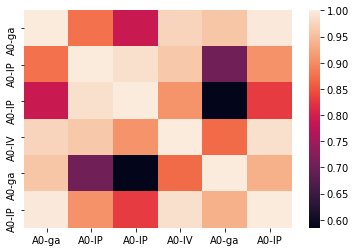

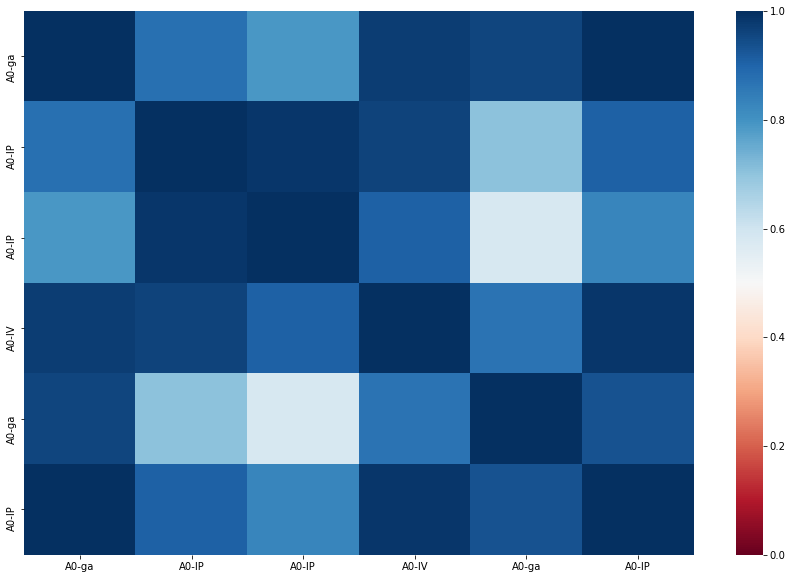

In [9]:

#---------beginning of the cluster section


import seaborn as sns
sns.heatmap(corrtotal, annot=False)
plt.show()
plt.figure(figsize=(15,10))

#===>
data=total
correlatedData = data.corr()
#turn annot=True to show the values in each square
sns.heatmap(round(correlatedData,3), cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=0, vmax=1);

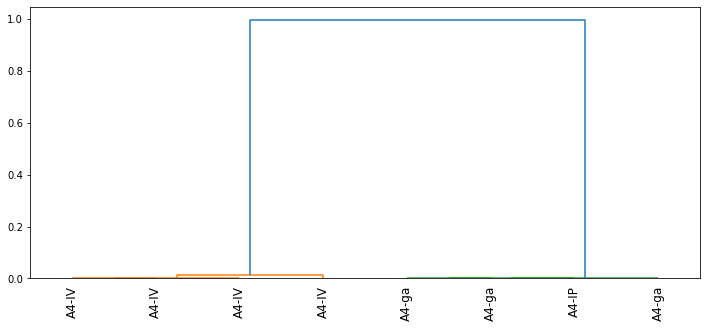

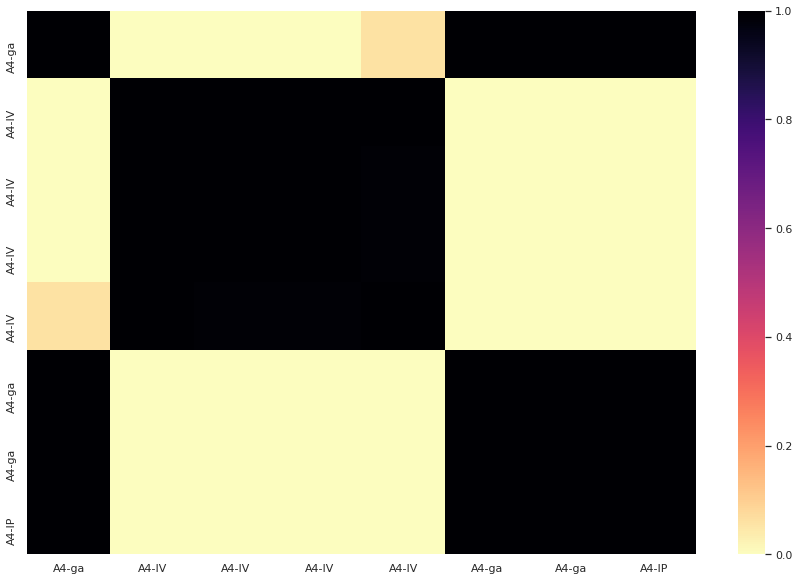

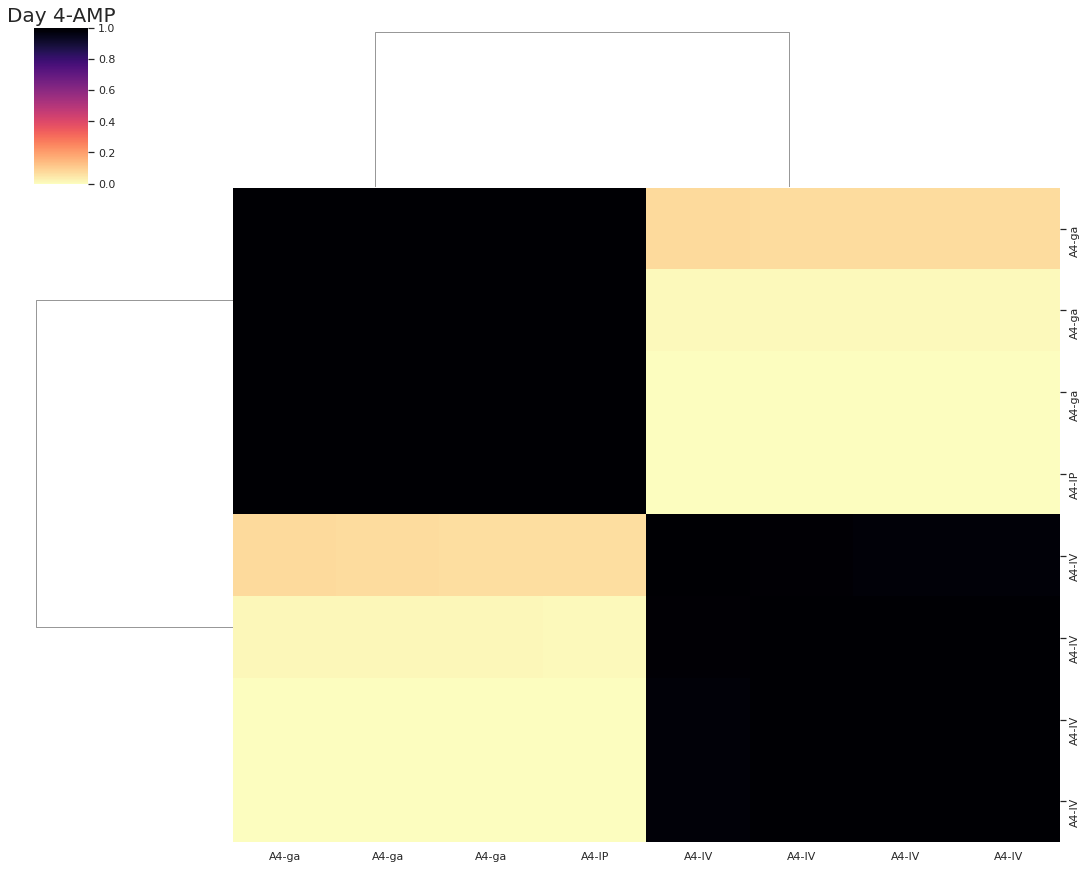

In [4]:
#part of hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.spatial import distance
plt.figure(figsize=(12,5))
dissimilarity = 1- abs(data.corr())
#Z is the cluster linkage array, it contains the hierarchical clustering information
#Z = linkage(data.corr(), 'ward')
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=data.columns, orientation='top',distance_sort='descending' ,
           leaf_rotation=90,leaf_font_size=12);
# Clusterize the data
threshold = 0.99

labels = fcluster(Z, threshold, criterion='distance')
# Show the cluster
#labels
#a1=distance.jensenshannon(vanMat,mixMat) plt.plot(a1)




labels_order = labels
# Keep the indices to sort labels
#labels_order = np.argsort(labels)--this will show alternate labels

# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)


sns.set_theme(color_codes=True)
sns.set(font_scale=1)

plt.figure(figsize=(15,10))
#correlations = clustered.corr()

sns.heatmap(round(correlatedData,2), cmap='magma_r', annot=False,xticklabels=True, yticklabels=True,
           annot_kws={"size": 7}, vmin=.0, vmax=1); 

sns.clustermap(correlatedData, method="complete", cmap='magma_r', annot=False, standard_scale=1, metric="correlation",
               linewidth=.0,xticklabels=True, yticklabels=True,
               annot_kws={"size": 7}, vmin=0., vmax=1, figsize=(15,12))

plt.title('Day 4-AMP', fontsize = 20)
plt.show()


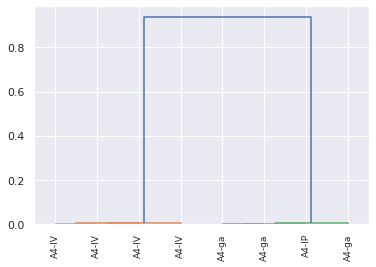

In [5]:
import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
distMatrix=1-corrtotal
distArray = ssd.squareform(distMatrix)
# define linkage object
distLinkage = hierarchy.linkage(distArray)

# make clustermap
#sns.clustermap(distMatrix, row_linkage=distLinkage, col_linkage=distLinkage)

dendrogram(distLinkage, labels=data.columns, orientation='top',distance_sort='descending' ,
           leaf_rotation=90,leaf_font_size=9);

In [ ]:
#the average correlation for each antibiotic through the days 0,1 and 4
import matplotlib.pyplot as plt
from matplotlib import style

dfX=[[0,0.88],[1,0.70],[4,0.42]]
dfA=[[0,0.85],[1,0.6],[4,0.44]]
dfC=[[0,0.95],[1,0.95],[4,0.95]]
dfM=[[0,0.92],[1,0.97],[4,0.97]]
dfN=[[0,0.91],[1,0.82],[4,0.83]]
dfV=[[0,0.9],[1,0.53],[4,0.36]]

x1, y1= zip(*dfX)
x2, y2= zip(*dfA)
x3, y3= zip(*dfC)
x4, y4= zip(*dfM)
x5, y5= zip(*dfN)
x6, y6= zip(*dfV)

plt.plot(x2,y2,color='blue',label='Amp')
plt.plot(x4,y4,color='orange',label='Met')
plt.plot(x3,y3,color='green',label='PBS')
plt.plot(x6,y6,color='red',label='Van')
plt.plot(x1,y1,color='purple',label='Mix')
plt.plot(x5,y5,color='brown',label='Neo')


plt.title('All deliveries, day-by-day')
plt.ylabel('average correlation')
plt.xlabel('day')

plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=5)

plt.legend(bbox_to_anchor=(1.2, 1.05),fancybox=True,shadow=True)

plt.style.use('seaborn-poster')
plt.show()


In [ ]:
print(plt.style.available)

In [103]:
#this is a trial for PCA analysis
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.datasets import load_boston


df = data
n_components = 6

pca = PCA(n_components=n_components)
components = pca.fit_transform(df)

total_var = pca.explained_variance_ratio_.sum() * 100

#labels = {str(i): f"PC {i+1}" for i in range(n_components)}
fig = px.scatter_matrix(
    components,
    dimensions=range(n_components)
   )
fig.update_traces(diagonal_visible=True)
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [15]:
data

array([[1.02801336e-04, 4.59110768e-01, 1.38781804e-03, 2.49807247e-02,
        0.00000000e+00, 5.01619121e-01, 0.00000000e+00, 7.86430224e-03,
        0.00000000e+00, 4.42045747e-03, 0.00000000e+00, 5.14006682e-04],
       [0.00000000e+00, 7.14231394e-01, 4.49376059e-04, 7.25915172e-03,
        0.00000000e+00, 2.74499637e-01, 0.00000000e+00, 2.66168896e-03,
        0.00000000e+00, 7.60482561e-04, 0.00000000e+00, 1.38269557e-04],
       [1.27967240e-04, 8.13743682e-01, 5.11868962e-04, 7.67803442e-04,
        0.00000000e+00, 1.80305842e-01, 0.00000000e+00, 2.43137757e-03,
        0.00000000e+00, 2.11145947e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.68401992e-01, 3.34993210e-03, 1.24943413e-02,
        0.00000000e+00, 4.08782254e-01, 0.00000000e+00, 5.88501584e-03,
        0.00000000e+00, 7.24309642e-04, 3.62154821e-04, 0.00000000e+00],
       [0.00000000e+00, 3.31309251e-01, 9.91387323e-04, 2.14387509e-02,
        0.00000000e+00, 6.38763244e-01, 0.00000000e+00, 4.83

In [ ]:
#https://towardsdatascience.com/principal-components-analysis-plot-for-python-311013a33cd9
from sklearn import datasets
from matplotlib import cm
from numpy import linspace

import pandas as pd
X=total

from sklearn.decomposition import PCA
columns=X.columns.values #Store the name of the columns for labeling
pca=PCA(n_components=4)
pca.fit(X)
pca_values=pca.components_

#----------
#Plot circle
#Create a list of 500 points with equal spacing between -1 and 1
import numpy as np

#x=np.linspace(start=-1,stop=1,num=500)
#Find y1 and y2 for these points
#rb=.7    #radius bigger circle
#y_positive=lambda x: np.sqrt(rb-x**2) 
#y_negative=lambda x: -np.sqrt(rb-x**2)
#plt.plot(x,list(map(y_positive, x)), color='maroon')
#plt.plot(x,list(map(y_negative, x)),color='maroon')

#------------
#Plot smaller circle
x=np.linspace(start=-0.5,stop=0.5,num=500)
rs=0.5  #radius smalles circle
y_positive=lambda x: np.sqrt(rs**2-x**2) 
y_negative=lambda x: -np.sqrt(rs**2-x**2)
plt.plot(x,list(map(y_positive, x)), color='maroon')
plt.plot(x,list(map(y_negative, x)),color='maroon')

#------------
#Create broken lines
x=np.linspace(start=-rs,stop=rs,num=30)
plt.scatter(x,[0]*len(x), marker='_',color='maroon')
plt.scatter([0]*len(x), x, marker='|',color='maroon')

#Define color list



start = 0.0
stop = 1.0
number_of_lines= total.shape[1]
cm_subsection = linspace(start, stop, number_of_lines) 

color = [ cm.RdBu(x) for x in cm_subsection ]


#--------

for i in range(len(pca_values[0])):
    xi=pca_values[0][i]
    yi=pca_values[1][i]
    plt.arrow(0,0, 
              dx=xi, dy=yi, 
              head_width=0.03, head_length=0.1, 
              color=color[i], length_includes_head=True)
    
#---------
plt.xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
plt.ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
plt.title('Variable factor map (PCA)')
plt.show()

In [10]:
m0=pd.DataFrame( pd.read_csv("meta_lumen.csv") )
#-----Takes only the first two letters for delivery,e.g.: gavage->ga
#-----Use the single letter definition for antibiotics: A->ampicilin, N->Neomycin, X->mix....
m0['SampleID']=m0['#SampleID']
m0['treat']=m0['SampleID'].apply(lambda x: x[:4])+m0['SampleID'].apply(lambda x: x[-1])+'-'+m0['treatment'].apply(lambda x: x[:2])
meta=m0[['SampleID']+['treat']]
#--------
#--treathead tells us wich delivery was used in each sample. Follows the sample order in modData
treathead=pd.merge(left=headers_list,right=meta,left_on='SampleID', right_on='SampleID')
treathead

,SampleID,treat
0,A1.d0,A1.d0-ga
1,A10.d0,A10.0-IP
2,A11.d0,A11.0-IP
3,A13.d0,A13.0-IV
4,A2.d0,A2.d0-ga
5,A8.d0,A8.d0-IP


In [11]:
group2=modData.groupby(["Phylum"]).sum()
group2
#-----Weighted Unifrac part -- following  http://scikit-bio.org/docs/0.4.1/diversity.html
#for the Unifrac part, the tree representation will be necessary, see http://scikit-bio.org/docs/0.5.1/tree.html
data=(group2.T).to_numpy()
#ids=headers
ids=treathead['treat'].to_list()
from skbio.diversity import alpha_diversity
#compute observed OTUs, an alpha diversity metric, for each sample using the alpha_diversity driver function
adiv_obs_otus = alpha_diversity('observed_otus', data, ids)
adiv_obs_otus


A1.d0-ga    8
A10.0-IP    7
A11.0-IP    7
A13.0-IV    7
A2.d0-ga    7
A8.d0-IP    7
dtype: int64

In [12]:
group2

,A1.d0,A10.d0,A11.d0,A13.d0,A2.d0,A8.d0
Phylum,,,,,,
Actinobacteria,0.000103,0.000000,0.000128,0.000000,0.000000,0.000000
Bacteroidetes,0.459111,0.714231,0.813744,0.568402,0.331309,0.498425
Cyanobacteria,0.001388,0.000449,0.000512,0.003350,0.000991,0.000426
Deferribacteres,0.024981,0.007259,0.000768,0.012494,0.021439,0.009236
Euryarchaeota,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Firmicutes,0.501619,0.274500,0.180306,0.408782,0.638763,0.480763
Fusobacteria,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Proteobacteria,0.007864,0.002662,0.002431,0.005885,0.004833,0.007576
TM7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
from skbio import TreeNode
from io import StringIO
tree = TreeNode.read(StringIO("((Actinobacteria,Bacteroidetes,Cyanobacteria, \
                              Deferribacteres,Euryarchaeota,Firmicutes, \
                              Fusobacteria,Proteobacteria,TM7,Tenericutes, \
                              Verrucomicrobia,Other)phylum)AMP;"))
otu_ids=['Actinobacteria', 'Bacteroidetes', 'Cyanobacteria', 'Deferribacteres',
       'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Proteobacteria', 'TM7',
       'Tenericutes', 'Verrucomicrobia', 'Other']

for n in tree.postorder(include_self=True):
    if n.length is None:
        n.length = 0

print(tree.ascii_art())

                    /-Actinobacteria
                   |
                   |--Bacteroidetes
                   |
                   |--Cyanobacteria
                   |
                   |--Deferribacteres
                   |
                   |--Euryarchaeota
                   |
                   |--Firmicutes
-AMP----- /phylum--|
                   |--Fusobacteria
                   |
                   |--Proteobacteria
                   |
                   |--TM7
                   |
                   |--Tenericutes
                   |
                   |--Verrucomicrobia
                   |
                    \-Other


In [14]:
adiv_faith_pd = alpha_diversity('faith_pd', data, ids=ids,
                                 otu_ids=otu_ids, tree=tree)
adiv_faith_pd

A1.d0-ga    0.0
A10.0-IP    0.0
A11.0-IP    0.0
A13.0-IV    0.0
A2.d0-ga    0.0
A8.d0-IP    0.0
dtype: float64

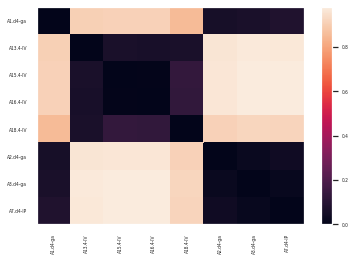

<Figure size 1800x720 with 0 Axes>

In [96]:
#compute Bray-Curtis distances, a beta diversity metric, between all pairs of samples
#I am (on August 12) working with each antibiotic individually
from skbio.diversity import beta_diversity
import seaborn as sns
bc_dm = beta_diversity("braycurtis", data, ids)
sns.set(font_scale=.4)
plt.figure(figsize=(25,10))
bc_dm

In [98]:
#Next, we’ll compute weighted UniFrac distances between all pairs of samples.
#Because weighted UniFrac is a phylogenetic beta diversity metric, we’ll need to
#pass the skbio.TreeNode and list of OTU ids that we created above. 
#Again, these are the same values that were provided to alpha_diversity
wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree,
                        otu_ids=otu_ids)
print(wu_dm)

8x8 distance matrix
IDs:
'A1.d4-ga', 'A13.4-IV', 'A15.4-IV', 'A16.4-IV', 'A18.4-IV', 'A2.d4-ga', ...
Data:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [100]:
>>> from skbio.stats.ordination import pcoa
>>> wu_pc = pcoa(wu_dm)


/home/turgon/anaconda3/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:188: RuntimeWarning: invalid value encountered in true_divide
  proportion_explained = eigvals / sum_eigenvalues


In [72]:
from skbio import TreeNode
from io import StringIO
tree = TreeNode.read(StringIO("((A1.d4,A13.d4,A15.d4,A16.d4,A18.d4,A2.d4,A3.d4,A7.d4)Amp)samples;"))
otu_ids=['A1.d4', 'A13.d4', 'A15.d4', 'A16.d4', 'A18.d4', 'A2.d4', 'A3.d4',
       'A7.d4']
print(tree.ascii_art())

                    /-A1.d4
                   |
                   |--A13.d4
                   |
                   |--A15.d4
                   |
                   |--A16.d4
-samples- /Amp-----|
                   |--A18.d4
                   |
                   |--A2.d4
                   |
                   |--A3.d4
                   |
                    \-A7.d4


In [32]:
len(tree)

1

In [33]:
len(otu_ids)

8

In [38]:
len(data)

8

In [112]:
tree = TreeNode.read(StringIO("((A1.d4,A13.d4,A15.d4,A16.d4,A18.d4,A2.d4,A3.d4,A7.d4)Amp, \
                                (C10.d4,C11.d4,C13.d4,C15.d4,C16.d4,C2.d4,C3.d4,C4.d4,C5.d4,C6.d4,C7.d4,C8.d4,C9.d4)PBS, \
                                (M1.d4,M11.d4,M12.d4,M13.d4,M14.d4,M15.d4,M16.d4,M17.d4,M18.d4,M2.d4,M3.d4,M4.d4,M5.d4,M7.d4,M8.d4,M9.d4)Met, \
                                (N1.d4,N10.d4,N11.d4,N12.d4,N15.d4,N16.d4,N17.d4,N18.d4,N2.d4,N4.d4,N6.d4,N7.d4,N9.d4)Neo, \
                                (V1.d4,V10.d4,V11.d4,V12.d4,V13.d4,V15.d4,V18.d4,V2.d4,V3.d4,V5.d4,V7.d4,V8.d4,V9.d4)Van, \
                                (X1.d4,X10.d4,X12.d4,X14.d4,X15.d4,X16.d4,X18.d4,X8.d4)Mix)samples;"))
otu_ids=['A1.d4', 'A13.d4', 'A15.d4', 'A16.d4', 'A18.d4', 'A2.d4', 'A3.d4',
       'A7.d4', 'C10.d4', 'C11.d4', 'C13.d4', 'C15.d4', 'C16.d4', 'C2.d4',
       'C3.d4', 'C4.d4', 'C5.d4', 'C6.d4', 'C7.d4', 'C8.d4', 'C9.d4', 'M1.d4',
       'M11.d4', 'M12.d4', 'M13.d4', 'M14.d4', 'M15.d4', 'M16.d4', 'M17.d4',
       'M18.d4', 'M2.d4', 'M3.d4', 'M4.d4', 'M5.d4', 'M7.d4', 'M8.d4', 'M9.d4',
       'N1.d4', 'N10.d4', 'N11.d4', 'N12.d4', 'N15.d4', 'N16.d4', 'N17.d4',
       'N18.d4', 'N2.d4', 'N4.d4', 'N6.d4', 'N7.d4', 'N9.d4', 'V1.d4',
       'V10.d4', 'V11.d4', 'V12.d4', 'V13.d4', 'V15.d4', 'V18.d4', 'V2.d4',
       'V3.d4', 'V5.d4', 'V7.d4', 'V8.d4', 'V9.d4', 'X1.d4', 'X10.d4',
       'X12.d4', 'X14.d4', 'X15.d4', 'X16.d4', 'X18.d4', 'X8.d4']
print(tree.ascii_art())

                    /-A1.d4
                   |
                   |--A13.d4
                   |
                   |--A15.d4
                   |
                   |--A16.d4
          /Amp-----|
         |         |--A18.d4
         |         |
         |         |--A2.d4
         |         |
         |         |--A3.d4
         |         |
         |          \-A7.d4
         |
         |          /-C10.d4
         |         |
         |         |--C11.d4
         |         |
         |         |--C13.d4
         |         |
         |         |--C15.d4
         |         |
         |         |--C16.d4
         |         |
         |         |--C2.d4
         |         |
         |-PBS-----|--C3.d4
         |         |
         |         |--C4.d4
         |         |
         |         |--C5.d4
         |         |
         |         |--C6.d4
         |         |
         |         |--C7.d4
         |         |
         |         |--C8.d4
         |         |
         |          \

In [114]:
len(otu_ids)

71

In [129]:
from skbio import TreeNode
from io import StringIO
#follows the kingdim > phylum > family
tree = TreeNode.read(StringIO("((Actinomyc,Bifido,Corio,Coryne,Micrococ,Myobac)Actinobac, \
                                (Bacter,Porphyr,Prevot,Riken,S24-7,Other,Odorib)Bacteroid, \
                                (Other)Cyanobac, \
                                (Deferri)Deferri, \
                                (Methano)Eury, \
                                (Aeroc,Christ,Clostrid,Dehal,Entero,Erysip,Eubact,\
                                Gemel,Lachno,Lactobac,Peptoc,Peptos,Ruminoc,Staphyloc, \
                                Strept,Turic,Veillo,Other,Mogibact)Firmicutes, \
                                (Leptotrich)Fusobac, \
                                (Alcal,Burkhol,Desul,Enterobac, \
                                 Neisser,Pasteur,Other)Proteobac, \
                                (F16)TM7, \
                                (Anaero,Other)Tenericures, \
                                (Verrucom)Verrucom, \
                                (Other)Other)phylum;"))
otu_ids=['Actinomycetaceae', 'Bifidobacteriaceae', 'Coriobacteriaceae',
       'Corynebacteriaceae', 'Micrococcaceae', 'Mycobacteriaceae',
       'Bacteroidaceae', 'Porphyromonadaceae', 'Prevotellaceae',
       'Rikenellaceae', 'S24-7', 'X1', '[Odoribacteraceae]', 'X2',
       'Deferribacteraceae', 'Methanobacteriaceae', 'Aerococcaceae',
       'Christensenellaceae', 'Clostridiaceae', 'Dehalobacteriaceae',
       'Enterococcaceae', 'Erysipelotrichaceae', 'Eubacteriaceae',
       'Gemellaceae', 'Lachnospiraceae', 'Lactobacillaceae', 'Peptococcaceae',
       'Peptostreptococcaceae', 'Ruminococcaceae', 'Staphylococcaceae',
       'Streptococcaceae', 'Turicibacteraceae', 'Veillonellaceae', 'X3',
       '[Mogibacteriaceae]', 'Leptotrichiaceae', 'Alcaligenaceae',
       'Burkholderiaceae', 'Desulfovibrionaceae', 'Enterobacteriaceae',
       'Neisseriaceae', 'Pasteurellaceae', 'X4', 'F16', 'Anaeroplasmataceae',
       'X', 'Verrucomicrobiaceae', 'X5']
#print(tree.is_root()) # is this the root of the tree?
#print(tree.is_tip()) # is this node a tip?

print(tree.ascii_art())

                    /-Actinomyc
                   |
                   |--Bifido
                   |
                   |--Corio
          /Actinobac
         |         |--Coryne
         |         |
         |         |--Micrococ
         |         |
         |          \-Myobac
         |
         |          /-Bacter
         |         |
         |         |--Porphyr
         |         |
         |         |--Prevot
         |         |
         |-Bacteroid--Riken
         |         |
         |         |--S24-7
         |         |
         |         |--Other
         |         |
         |          \-Odorib
         |
         |-Cyanobac /-Other
         |
         |-Deferri- /-Deferri
         |
         |-Eury---- /-Methano
         |
         |          /-Aeroc
         |         |
         |         |--Christ
         |         |
         |         |--Clostrid
         |         |
         |         |--Dehal
         |         |
         |         |--Entero
         |        

In [28]:
tree.is_root()

True

In [92]:

div_faith_pd = alpha_diversity('faith_pd', data, ids=ids,otu_ids=otu_ids, tree=tree)
adiv_faith_pd

A1.d4-ga    0.0
A13.4-IV    0.0
A15.4-IV    0.0
A16.4-IV    0.0
A18.4-IV    0.0
A2.d4-ga    0.0
A3.d4-ga    0.0
A7.d4-IP    0.0
dtype: float64

In [93]:
>>> wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree,
...                        otu_ids=otu_ids)
>>> print(wu_dm)

8x8 distance matrix
IDs:
'A1.d4-ga', 'A13.4-IV', 'A15.4-IV', 'A16.4-IV', 'A18.4-IV', 'A2.d4-ga', ...
Data:
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
